In [1]:
# This class tests the classical and ggn versions of curveball method.

In [7]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.tensorflow2 import Curveball, NonLinearConjugateGradient

tf.get_logger().setLevel('ERROR')
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def fun_rosenbrock(x):
    # outputs the residuals
    y1 = 10 * (x[1:] - x[:-1]**2)
    y2 = 1 - x[:-1]
    return tf.concat((y1, y2), axis=0)

def fun_loss(x):
    return 0.5 * tf.reduce_sum(x**2)

def ggn_preds_fn(v):
    return v
def ggn_loss_fn(v):
    return fun_loss(fun_rosenbrock(v))

In [5]:
z_init = tf.zeros(10)

In [20]:
# Tensorflow
v1 = tf.Variable(z_init, dtype='float32')
v2 = tf.Variable(z_init, dtype='float32')
v3 = tf.Variable(z_init, dtype='float32')

cb1 = Curveball(predictions_fn=fun_rosenbrock, loss_fn=fun_loss, input_var=v1, name='cb1', damping_factor=10)
cb2 = Curveball(predictions_fn=ggn_preds_fn, loss_fn=ggn_loss_fn, input_var=v2, name='cb2', damping_factor=10)
nlcg_opt = NonLinearConjugateGradient(objective_fn=ggn_loss_fn, input_var=v3, name='cg')

In [21]:
%%time 
cb1_losses = []
cb2_losses = []
for i in range(100):
    cb1_losses.append(cb1.minimize().numpy())
    if i %10 == 0:
        print(cb1_losses[-1])

4.449641
3.3076782
2.369151
1.4390404
0.57092047
0.09022296
0.038870674
0.019140748
0.010106588
0.005557982
CPU times: user 1.23 s, sys: 52.1 ms, total: 1.28 s
Wall time: 1.03 s


In [22]:
%%time 
cb2_losses = []
for i in range(100):
    cb2_losses.append(cb2.minimize().numpy())
    if i %10 == 0:
        print(cb2_losses[-1])

4.449641
3.2960358
2.3895068
1.524221
0.71631837
0.19926429
0.06800495
0.031105377
0.015711933
0.008398119
CPU times: user 1.61 s, sys: 79.2 ms, total: 1.69 s
Wall time: 1.42 s


In [23]:
%%time 
cg_losses = []
for i in range(100):
    cg_losses.append(nlcg_opt.minimize().numpy())
    if i %10 == 0:
        print(cg_losses[-1])

4.480915
4.204812
3.1979737
2.431549
2.2820477
1.8382661
1.644171
1.3159117
1.1637033
1.0904851
CPU times: user 1.06 s, sys: 57.8 ms, total: 1.12 s
Wall time: 854 ms


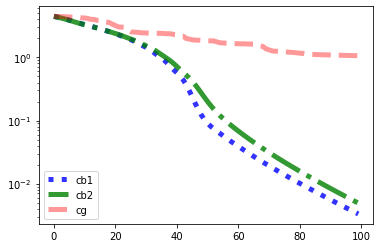

In [24]:
# The discrepancy here is because curveball requires a matrix inversion step
# the matrix becomes singular fairly often
# I tried calculating the pseudo inverse myself, but all the approach I tried for this 
# in tensorflow game solutions less stable and accurate than the numpy counterpart.
plt.plot(cb1_losses, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='cb1')
plt.plot(cb2_losses, color='green', ls='-.', linewidth=5.0, alpha=0.8, label='cb2')
plt.plot(cg_losses, color='red', ls='--', linewidth=5.0, alpha=0.4, label='cg')
plt.yscale('log')
plt.legend(loc='best')
plt.show()